# Import Libraries

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shutil
import random
import sys
import threading
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import ParameterGrid
from torchsummary import summary
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

#  Global Variable 

In [58]:
dataset_path  = "DATA"
train_dataset_path = "DATA/train"
validation_dataset_path = "DATA/validation"
test_dataset_path = "DATA/test"

# Move model to a device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
input_shape = (3, 96, 96)
num_classes = 5
"""
num_epochs = 20
# Paramenter for HyperParameter search for all network
param_grid = {
    'learning_rate': [0.01, 0.001, 0.0001],
    'batch_size': [32, 64],
    'optimizer': ['Adam', 'SGD']
}
"""
# Only for the Long Train they are the best params
num_epochs = 100
param_grid = {
    'learning_rate': [0.01],
    'batch_size': [32],
    'optimizer': ['SGD']
}


action_labels = {
    "0": "Do Nothing",
    "1": "Steer Left",
    "2": "Steer Right",
    "3": "Gas",
    "4": "Brake"
}

cuda


# Dataset

In [70]:
# Transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.RandomApply([
        transforms.RandomRotation(degrees=(-15, -15), interpolation=Image.BILINEAR),
        transforms.RandomRotation(degrees=(15, 15), interpolation=Image.BILINEAR)
    ], p=0.5), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
])

# Create datasets
train_dataset = datasets.ImageFolder(train_dataset_path, transform=transform)
validation_dataset = datasets.ImageFolder(validation_dataset_path, transform=transform_test)
test_dataset = datasets.ImageFolder(test_dataset_path, transform=transform_test)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 5733
Number of validation samples: 5733
Number of test samples: 2749


# 3 CNN 
As observed from the training of previous models, applying tensor.transform on tensors during training helps to reduce overfitting. An additional approach I now wish to explore is initializing the weights in an orthonormal manner, rather than using the default random initialization provided by PyTorch. This will allow us to evaluate how this change impacts the model's performance.

In [24]:
def create_cnn_orthogonal_model(input_shape=(3, 96, 96), num_classes=5):
    """
    Creates a deeper CNN model for image classification using PyTorch with orthonormal weight initialization.

    Args:
        input_shape (tuple): Shape of the input images (channels, height, width).
        num_classes (int): Number of classes for classification.

    Returns:
        nn.Module: CNN model.
    """
    class CNNModel(nn.Module):
        def __init__(self):
            super(CNNModel, self).__init__()
            
            # Convolutional Layers
            self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
            self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
            self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
            
            # Pooling Layer
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

            # Calculate the size of the flattened layer dynamically
            dummy_input = torch.zeros(1, *input_shape)
            x = self.pool(F.relu(self.conv1(dummy_input)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
            flattened_size = x.numel()

            # Fully Connected Layers
            self.fc1 = nn.Linear(flattened_size, 64)
            self.fc2 = nn.Linear(64, num_classes)

            # Apply orthonormal initialization to layers
            self._initialize_weights()

        def _initialize_weights(self):
            """
            Apply orthonormal initialization to all applicable layers.
            """
            for layer in self.modules():
                if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                    nn.init.orthogonal_(layer.weight)
                    if layer.bias is not None:
                        nn.init.constant_(layer.bias, 0)

        def forward(self, x):
            # Convolutional layers with ReLU and Pooling
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))

            # Flatten
            x = x.view(x.size(0), -1)

            # Fully connected layers
            x = F.relu(self.fc1(x))
            x = self.fc2(x)

            return x

    return CNNModel()

# Create and move the model to the device
model = create_cnn_orthogonal_model()
model = model.to(device)

# Print the summary of the model
summary(model, input_size=input_shape, device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 96, 96]             448
         MaxPool2d-2           [-1, 16, 48, 48]               0
            Conv2d-3           [-1, 32, 48, 48]           4,640
         MaxPool2d-4           [-1, 32, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          18,496
         MaxPool2d-6           [-1, 64, 12, 12]               0
            Linear-7                   [-1, 64]         589,888
            Linear-8                    [-1, 5]             325
Total params: 613,797
Trainable params: 613,797
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 2.46
Params size (MB): 2.34
Estimated Total Size (MB): 4.91
----------------------------------------------------------------


# Train and Test

In [7]:
def plot_loss(save_path, name_plot, best_model_info):

    # Plotting train loss and validation loss
    plt.subplot(2, 1, 1)
    plt.plot(best_model_info["epoch"], best_model_info["train_loss"], label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training Loss")
    
    # Plotting train accuracy
    plt.subplot(2, 1, 2)
    plt.plot(best_model_info["epoch"],  best_model_info["train_accuracy"], label="Train Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training Accuracy")

    plt.tight_layout()
    plt.savefig(os.path.join(save_path, name_plot))
    plt.show()

In [8]:
def test_model(model, model_path, test_loader, device, show):
    if show:
        model.load_state_dict(torch.load(model_path, weights_only=False)['model_state_dict'])
        
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {accuracy:.4f}")

    # Creation of Report
    if show:
        report = classification_report(all_labels, all_preds, target_names=test_loader.dataset.classes)
    else:
        report = classification_report(all_labels, all_preds, target_names=test_loader.dataset.classes, output_dict=True)
    if show:
        print("Classification Report:\n", report)

    # Confusion Matrix
    if show:
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_loader.dataset.classes, yticklabels=test_loader.dataset.classes)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()

    return accuracy, report

In [9]:
def train_model(model, train_loader, optimizer, criterion, device, num_epochs):
    model.to(device)

    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        print(f"Epoch {epoch + 1}/{num_epochs}")

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()

            train_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss /= len(train_loader)
        train_accuracy = correct / total

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    return train_losses, train_accuracies

In [10]:
def hyperparameter_search(train_data, validation_data, param_grid, save_path, name_model, num_epochs, device):
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    best_params = None
    best_accuracy = 0
    best_f1_score = 0
    best_recall = 0
    best_precision = 0
    best_model_info = None

    results_file_path = os.path.join(save_path, f"{name_model}_results.txt")
    with open(results_file_path, "w") as results_file:
        for params in ParameterGrid(param_grid):
            print(f"Testing params: {params}")

            model = create_cnn_orthogonal_model()

            # Initialize optimizer and loss function
            optimizer = getattr(torch.optim, params['optimizer'])(model.parameters(), lr=params['learning_rate'])
            criterion = nn.CrossEntropyLoss()

            # Create DataLoader
            train_loader = DataLoader(train_data, batch_size=params['batch_size'], shuffle=True)
            validation_loader = DataLoader(validation_data, batch_size=64, shuffle=False)

            # Train model and collect losses and predictions
            train_losses, train_accuracies = train_model(model, train_loader, optimizer, criterion, device, num_epochs)

            # Evaluate model on validation set
            model_path = None
            accuracy, classification_metrics = test_model(model, model_path, validation_loader, device, show=False)

            # Compute average precision, recall, and F1-score across all classes
            precision_avg = classification_metrics['weighted avg']['precision']
            recall_avg = classification_metrics['weighted avg']['recall']
            f1_score_avg = classification_metrics['weighted avg']['f1-score']

            # Save results to file
            results_file.write(f"MODEL BATCH_SIZE={params['batch_size']} LEARNING_RATE={params['learning_rate']} OPTIMIZER={params['optimizer']}\n")
            results_file.write(f"ACCURACY={accuracy} PRECISION={precision_avg} RECALL={recall_avg} F1_SCORE={f1_score_avg}\n\n")

            if accuracy > best_accuracy and precision_avg > best_precision:
                best_accuracy = accuracy
                best_f1_score = f1_score_avg
                best_precision = precision_avg
                best_recall = recall_avg
                best_params = params
                best_model_info = {
                    "epoch": list(range(1, num_epochs + 1)),
                    "train_loss": train_losses,
                    "train_accuracy": train_accuracies,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "hyperparameters": params
                }

                # Save the best model
                torch.save(best_model_info, os.path.join(save_path, name_model))

    print(f"Best Params: {best_params}, Best Accuracy: {best_accuracy}, Best Average Precision: {best_precision}")
    return best_params, best_model_info

In [25]:
name_plot="TRAIN_VAL_LOSS_3_CNN.png"
save_path="SAVE/ORTHOGONAL"
name_model="3_CNN.pth"
best_params, best_model_info = hyperparameter_search(train_dataset, validation_dataset,  param_grid, save_path, name_model, num_epochs, device)

print(f"Best hyperparameters: {best_params}")

Testing params: {'batch_size': 32, 'learning_rate': 0.01, 'optimizer': 'Adam'}
Epoch 1/20
Train Loss: 1.3878, Train Accuracy: 0.5622
Epoch 2/20
Train Loss: 1.0911, Train Accuracy: 0.6018
Epoch 3/20
Train Loss: 1.0333, Train Accuracy: 0.6185
Epoch 4/20
Train Loss: 0.9897, Train Accuracy: 0.6335
Epoch 5/20
Train Loss: 0.9298, Train Accuracy: 0.6531
Epoch 6/20
Train Loss: 0.8939, Train Accuracy: 0.6684
Epoch 7/20
Train Loss: 0.8428, Train Accuracy: 0.6895
Epoch 8/20
Train Loss: 0.8040, Train Accuracy: 0.6970
Epoch 9/20
Train Loss: 0.7543, Train Accuracy: 0.7185
Epoch 10/20
Train Loss: 0.7114, Train Accuracy: 0.7399
Epoch 11/20
Train Loss: 0.6890, Train Accuracy: 0.7422
Epoch 12/20
Train Loss: 0.6674, Train Accuracy: 0.7551
Epoch 13/20
Train Loss: 0.6310, Train Accuracy: 0.7619
Epoch 14/20
Train Loss: 0.5991, Train Accuracy: 0.7795
Epoch 15/20
Train Loss: 0.5910, Train Accuracy: 0.7828
Epoch 16/20
Train Loss: 0.5652, Train Accuracy: 0.7900
Epoch 17/20
Train Loss: 0.5549, Train Accuracy: 0.

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Train Loss: 1.4209, Train Accuracy: 0.4362
Epoch 2/20
Train Loss: 1.2444, Train Accuracy: 0.5554
Epoch 3/20
Train Loss: 1.1865, Train Accuracy: 0.5543
Epoch 4/20
Train Loss: 1.1676, Train Accuracy: 0.5678
Epoch 5/20
Train Loss: 1.1554, Train Accuracy: 0.5707
Epoch 6/20
Train Loss: 1.1396, Train Accuracy: 0.5829
Epoch 7/20
Train Loss: 1.1271, Train Accuracy: 0.5821
Epoch 8/20
Train Loss: 1.1215, Train Accuracy: 0.5852
Epoch 9/20
Train Loss: 1.1154, Train Accuracy: 0.5904
Epoch 10/20
Train Loss: 1.1057, Train Accuracy: 0.5897
Epoch 11/20
Train Loss: 1.1011, Train Accuracy: 0.5978
Epoch 12/20
Train Loss: 1.0957, Train Accuracy: 0.5945
Epoch 13/20
Train Loss: 1.0861, Train Accuracy: 0.5976
Epoch 14/20
Train Loss: 1.0822, Train Accuracy: 0.5964
Epoch 15/20
Train Loss: 1.0810, Train Accuracy: 0.6027
Epoch 16/20
Train Loss: 1.0699, Train Accuracy: 0.6018
Epoch 17/20
Train Loss: 1.0625, Train Accuracy: 0.6070
Epoch 18/20
Train Loss: 1.0637, Train Accuracy: 0.6056
Epoch 19/20
Train Loss: 1.0587

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Train Loss: 1.1811, Train Accuracy: 0.5571
Epoch 2/20
Train Loss: 1.0388, Train Accuracy: 0.6196
Epoch 3/20
Train Loss: 0.9652, Train Accuracy: 0.6429
Epoch 4/20
Train Loss: 0.8922, Train Accuracy: 0.6818
Epoch 5/20
Train Loss: 0.8296, Train Accuracy: 0.6942
Epoch 6/20
Train Loss: 0.7729, Train Accuracy: 0.7197
Epoch 7/20
Train Loss: 0.7080, Train Accuracy: 0.7415
Epoch 8/20
Train Loss: 0.6491, Train Accuracy: 0.7642
Epoch 9/20
Train Loss: 0.6033, Train Accuracy: 0.7837
Epoch 10/20
Train Loss: 0.5531, Train Accuracy: 0.8039
Epoch 11/20
Train Loss: 0.5025, Train Accuracy: 0.8212
Epoch 12/20
Train Loss: 0.4684, Train Accuracy: 0.8292
Epoch 13/20
Train Loss: 0.4217, Train Accuracy: 0.8502
Epoch 14/20
Train Loss: 0.3933, Train Accuracy: 0.8578
Epoch 15/20
Train Loss: 0.3604, Train Accuracy: 0.8702
Epoch 16/20
Train Loss: 0.3270, Train Accuracy: 0.8821
Epoch 17/20
Train Loss: 0.3039, Train Accuracy: 0.8917
Epoch 18/20
Train Loss: 0.2773, Train Accuracy: 0.8964
Epoch 19/20
Train Loss: 0.2604

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Train Loss: 1.5205, Train Accuracy: 0.3166
Epoch 2/20
Train Loss: 1.4776, Train Accuracy: 0.3407
Epoch 3/20
Train Loss: 1.4553, Train Accuracy: 0.3621
Epoch 4/20
Train Loss: 1.4338, Train Accuracy: 0.3979
Epoch 5/20
Train Loss: 1.4116, Train Accuracy: 0.4458
Epoch 6/20
Train Loss: 1.3888, Train Accuracy: 0.5039
Epoch 7/20
Train Loss: 1.3683, Train Accuracy: 0.5165
Epoch 8/20
Train Loss: 1.3442, Train Accuracy: 0.5317
Epoch 9/20
Train Loss: 1.3243, Train Accuracy: 0.5451
Epoch 10/20
Train Loss: 1.3056, Train Accuracy: 0.5501
Epoch 11/20
Train Loss: 1.2848, Train Accuracy: 0.5535
Epoch 12/20
Train Loss: 1.2697, Train Accuracy: 0.5589
Epoch 13/20
Train Loss: 1.2496, Train Accuracy: 0.5571
Epoch 14/20
Train Loss: 1.2360, Train Accuracy: 0.5617
Epoch 15/20
Train Loss: 1.2260, Train Accuracy: 0.5620
Epoch 16/20
Train Loss: 1.2152, Train Accuracy: 0.5592
Epoch 17/20
Train Loss: 1.2086, Train Accuracy: 0.5606
Epoch 18/20
Train Loss: 1.1991, Train Accuracy: 0.5597
Epoch 19/20
Train Loss: 1.1929

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Train Loss: 1.2650, Train Accuracy: 0.5205
Epoch 2/20
Train Loss: 1.1515, Train Accuracy: 0.5726
Epoch 3/20
Train Loss: 1.1157, Train Accuracy: 0.5910
Epoch 4/20
Train Loss: 1.0899, Train Accuracy: 0.6049
Epoch 5/20
Train Loss: 1.0584, Train Accuracy: 0.6115
Epoch 6/20
Train Loss: 1.0376, Train Accuracy: 0.6190
Epoch 7/20
Train Loss: 1.0254, Train Accuracy: 0.6217
Epoch 8/20
Train Loss: 1.0086, Train Accuracy: 0.6304
Epoch 9/20
Train Loss: 0.9870, Train Accuracy: 0.6393
Epoch 10/20
Train Loss: 0.9763, Train Accuracy: 0.6382
Epoch 11/20
Train Loss: 0.9553, Train Accuracy: 0.6501
Epoch 12/20
Train Loss: 0.9399, Train Accuracy: 0.6517
Epoch 13/20
Train Loss: 0.9314, Train Accuracy: 0.6557
Epoch 14/20
Train Loss: 0.9186, Train Accuracy: 0.6647
Epoch 15/20
Train Loss: 0.9065, Train Accuracy: 0.6670
Epoch 16/20
Train Loss: 0.8966, Train Accuracy: 0.6702
Epoch 17/20
Train Loss: 0.8907, Train Accuracy: 0.6768
Epoch 18/20
Train Loss: 0.8788, Train Accuracy: 0.6843
Epoch 19/20
Train Loss: 0.8667

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Train Loss: 1.5954, Train Accuracy: 0.3086
Epoch 2/20
Train Loss: 1.5751, Train Accuracy: 0.3318
Epoch 3/20
Train Loss: 1.5570, Train Accuracy: 0.3358
Epoch 4/20
Train Loss: 1.5435, Train Accuracy: 0.3269
Epoch 5/20
Train Loss: 1.5323, Train Accuracy: 0.3248
Epoch 6/20
Train Loss: 1.5238, Train Accuracy: 0.3189
Epoch 7/20
Train Loss: 1.5165, Train Accuracy: 0.3204
Epoch 8/20
Train Loss: 1.5097, Train Accuracy: 0.3187
Epoch 9/20
Train Loss: 1.5052, Train Accuracy: 0.3176
Epoch 10/20
Train Loss: 1.5006, Train Accuracy: 0.3148
Epoch 11/20
Train Loss: 1.4963, Train Accuracy: 0.3147
Epoch 12/20
Train Loss: 1.4921, Train Accuracy: 0.3143
Epoch 13/20
Train Loss: 1.4903, Train Accuracy: 0.3147
Epoch 14/20
Train Loss: 1.4873, Train Accuracy: 0.3145
Epoch 15/20
Train Loss: 1.4854, Train Accuracy: 0.3145
Epoch 16/20
Train Loss: 1.4843, Train Accuracy: 0.3147
Epoch 17/20
Train Loss: 1.4806, Train Accuracy: 0.3147
Epoch 18/20
Train Loss: 1.4780, Train Accuracy: 0.3147
Epoch 19/20
Train Loss: 1.4780

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Train Loss: 1.6011, Train Accuracy: 0.5385
Epoch 2/20
Train Loss: 1.0668, Train Accuracy: 0.6058
Epoch 3/20
Train Loss: 1.0028, Train Accuracy: 0.6274
Epoch 4/20
Train Loss: 0.9392, Train Accuracy: 0.6449
Epoch 5/20
Train Loss: 0.8892, Train Accuracy: 0.6721
Epoch 6/20
Train Loss: 0.8422, Train Accuracy: 0.6921
Epoch 7/20
Train Loss: 0.7963, Train Accuracy: 0.7021
Epoch 8/20
Train Loss: 0.7478, Train Accuracy: 0.7251
Epoch 9/20
Train Loss: 0.6961, Train Accuracy: 0.7394
Epoch 10/20
Train Loss: 0.6644, Train Accuracy: 0.7495
Epoch 11/20
Train Loss: 0.6165, Train Accuracy: 0.7701
Epoch 12/20
Train Loss: 0.5806, Train Accuracy: 0.7797
Epoch 13/20
Train Loss: 0.5683, Train Accuracy: 0.7895
Epoch 14/20
Train Loss: 0.5265, Train Accuracy: 0.8036
Epoch 15/20
Train Loss: 0.5007, Train Accuracy: 0.8080
Epoch 16/20
Train Loss: 0.4881, Train Accuracy: 0.8142
Epoch 17/20
Train Loss: 0.4537, Train Accuracy: 0.8275
Epoch 18/20
Train Loss: 0.4194, Train Accuracy: 0.8453
Epoch 19/20
Train Loss: 0.4168

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Train Loss: 1.5529, Train Accuracy: 0.2908
Epoch 2/20
Train Loss: 1.4946, Train Accuracy: 0.3223
Epoch 3/20
Train Loss: 1.4780, Train Accuracy: 0.3171
Epoch 4/20
Train Loss: 1.4662, Train Accuracy: 0.3171
Epoch 5/20
Train Loss: 1.4547, Train Accuracy: 0.3400
Epoch 6/20
Train Loss: 1.4439, Train Accuracy: 0.3872
Epoch 7/20
Train Loss: 1.4323, Train Accuracy: 0.4235
Epoch 8/20
Train Loss: 1.4196, Train Accuracy: 0.4706
Epoch 9/20
Train Loss: 1.4069, Train Accuracy: 0.4837
Epoch 10/20
Train Loss: 1.3944, Train Accuracy: 0.5074
Epoch 11/20
Train Loss: 1.3820, Train Accuracy: 0.5132
Epoch 12/20
Train Loss: 1.3699, Train Accuracy: 0.5236
Epoch 13/20
Train Loss: 1.3560, Train Accuracy: 0.5334
Epoch 14/20
Train Loss: 1.3449, Train Accuracy: 0.5372
Epoch 15/20
Train Loss: 1.3308, Train Accuracy: 0.5399
Epoch 16/20
Train Loss: 1.3186, Train Accuracy: 0.5423
Epoch 17/20
Train Loss: 1.3069, Train Accuracy: 0.5440
Epoch 18/20
Train Loss: 1.2968, Train Accuracy: 0.5458
Epoch 19/20
Train Loss: 1.2849

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Train Loss: 1.2872, Train Accuracy: 0.4976
Epoch 2/20
Train Loss: 1.1520, Train Accuracy: 0.5777
Epoch 3/20
Train Loss: 1.1181, Train Accuracy: 0.5871
Epoch 4/20
Train Loss: 1.0892, Train Accuracy: 0.5950
Epoch 5/20
Train Loss: 1.0573, Train Accuracy: 0.6096
Epoch 6/20
Train Loss: 1.0418, Train Accuracy: 0.6149
Epoch 7/20
Train Loss: 1.0212, Train Accuracy: 0.6241
Epoch 8/20
Train Loss: 1.0122, Train Accuracy: 0.6281
Epoch 9/20
Train Loss: 1.0028, Train Accuracy: 0.6286
Epoch 10/20
Train Loss: 0.9854, Train Accuracy: 0.6374
Epoch 11/20
Train Loss: 0.9679, Train Accuracy: 0.6450
Epoch 12/20
Train Loss: 0.9630, Train Accuracy: 0.6517
Epoch 13/20
Train Loss: 0.9444, Train Accuracy: 0.6536
Epoch 14/20
Train Loss: 0.9385, Train Accuracy: 0.6532
Epoch 15/20
Train Loss: 0.9399, Train Accuracy: 0.6513
Epoch 16/20
Train Loss: 0.9186, Train Accuracy: 0.6628
Epoch 17/20
Train Loss: 0.9080, Train Accuracy: 0.6675
Epoch 18/20
Train Loss: 0.9012, Train Accuracy: 0.6740
Epoch 19/20
Train Loss: 0.8889

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Train Loss: 1.5675, Train Accuracy: 0.3147
Epoch 2/20
Train Loss: 1.5471, Train Accuracy: 0.3143
Epoch 3/20
Train Loss: 1.5303, Train Accuracy: 0.3145
Epoch 4/20
Train Loss: 1.5171, Train Accuracy: 0.3147
Epoch 5/20
Train Loss: 1.5073, Train Accuracy: 0.3154
Epoch 6/20
Train Loss: 1.4997, Train Accuracy: 0.3157
Epoch 7/20
Train Loss: 1.4937, Train Accuracy: 0.3168
Epoch 8/20
Train Loss: 1.4883, Train Accuracy: 0.3183
Epoch 9/20
Train Loss: 1.4852, Train Accuracy: 0.3201
Epoch 10/20
Train Loss: 1.4816, Train Accuracy: 0.3204
Epoch 11/20
Train Loss: 1.4772, Train Accuracy: 0.3250
Epoch 12/20
Train Loss: 1.4753, Train Accuracy: 0.3246
Epoch 13/20
Train Loss: 1.4713, Train Accuracy: 0.3297
Epoch 14/20
Train Loss: 1.4699, Train Accuracy: 0.3297
Epoch 15/20
Train Loss: 1.4677, Train Accuracy: 0.3332
Epoch 16/20
Train Loss: 1.4662, Train Accuracy: 0.3359
Epoch 17/20
Train Loss: 1.4635, Train Accuracy: 0.3428
Epoch 18/20
Train Loss: 1.4620, Train Accuracy: 0.3475
Epoch 19/20
Train Loss: 1.4603

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

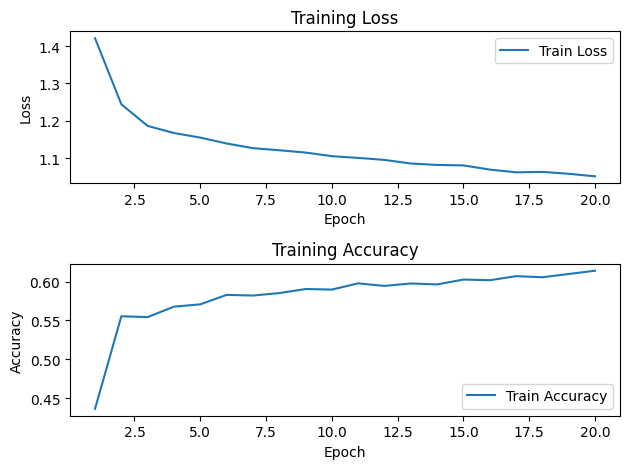

In [26]:
plot_loss(save_path, name_plot, best_model_info)

Test Accuracy: 0.7144
Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.22      0.29       133
           1       0.65      0.08      0.15       406
           2       0.70      0.14      0.24       275
           3       0.72      0.98      0.83      1896
           4       0.00      0.00      0.00        39

    accuracy                           0.71      2749
   macro avg       0.50      0.29      0.30      2749
weighted avg       0.69      0.71      0.63      2749



c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

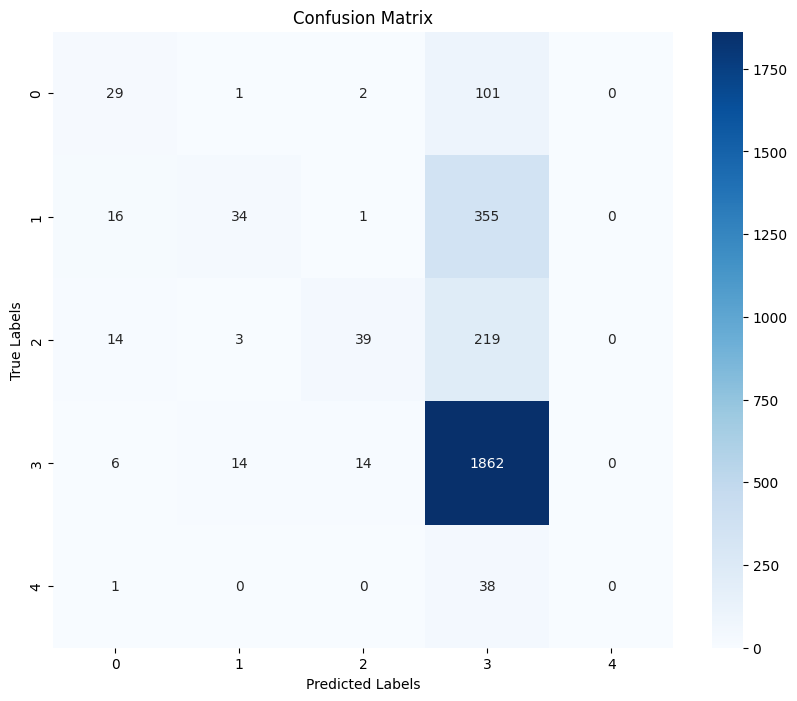

In [71]:

model_path = "SAVE/ORTHOGONAL/3_CNN.pth"
model = create_cnn_orthogonal_model()
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
accuracy, report = test_model(model, model_path, test_loader, device, show=True)

# Long Train

In [75]:
name_plot="LONG_TRAIN_LOSS_3_CNN.png"
save_path="SAVE/ORTHOGONAL"
name_model="LONG_3_CNN.pth"
best_params, best_model_info = hyperparameter_search(train_dataset, validation_dataset, param_grid, save_path, name_model, num_epochs, device)

print(f"Best hyperparameters: {best_params}")

Testing params: {'batch_size': 32, 'learning_rate': 0.01, 'optimizer': 'SGD'}
Epoch 1/100
Train Loss: 1.3999, Train Accuracy: 0.4514
Epoch 2/100
Train Loss: 1.2315, Train Accuracy: 0.5510
Epoch 3/100
Train Loss: 1.1807, Train Accuracy: 0.5662
Epoch 4/100
Train Loss: 1.1628, Train Accuracy: 0.5742
Epoch 5/100
Train Loss: 1.1442, Train Accuracy: 0.5810
Epoch 6/100
Train Loss: 1.1348, Train Accuracy: 0.5817
Epoch 7/100
Train Loss: 1.1262, Train Accuracy: 0.5866
Epoch 8/100
Train Loss: 1.1233, Train Accuracy: 0.5812
Epoch 9/100
Train Loss: 1.1178, Train Accuracy: 0.5882
Epoch 10/100
Train Loss: 1.1085, Train Accuracy: 0.5922
Epoch 11/100
Train Loss: 1.1001, Train Accuracy: 0.5901
Epoch 12/100
Train Loss: 1.0994, Train Accuracy: 0.5880
Epoch 13/100
Train Loss: 1.0947, Train Accuracy: 0.5945
Epoch 14/100
Train Loss: 1.0836, Train Accuracy: 0.5983
Epoch 15/100
Train Loss: 1.0848, Train Accuracy: 0.6046
Epoch 16/100
Train Loss: 1.0754, Train Accuracy: 0.5972
Epoch 17/100
Train Loss: 1.0722, Tr

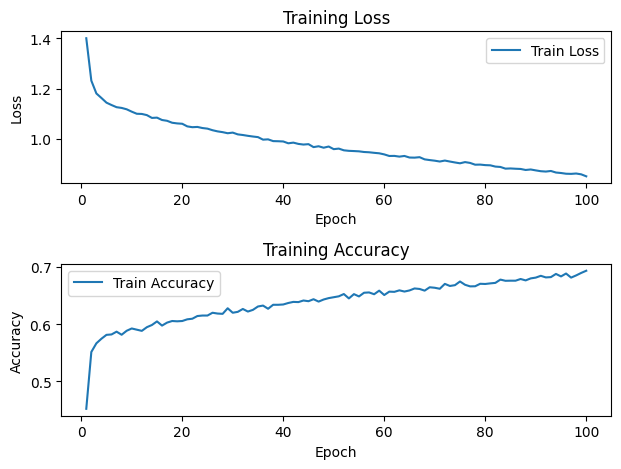

In [76]:
plot_loss(save_path, name_plot, best_model_info)

Test Accuracy: 0.6235
Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.42      0.34       133
           1       0.40      0.70      0.51       406
           2       0.42      0.37      0.40       275
           3       0.83      0.67      0.74      1896
           4       0.04      0.08      0.06        39

    accuracy                           0.62      2749
   macro avg       0.40      0.45      0.41      2749
weighted avg       0.69      0.62      0.64      2749



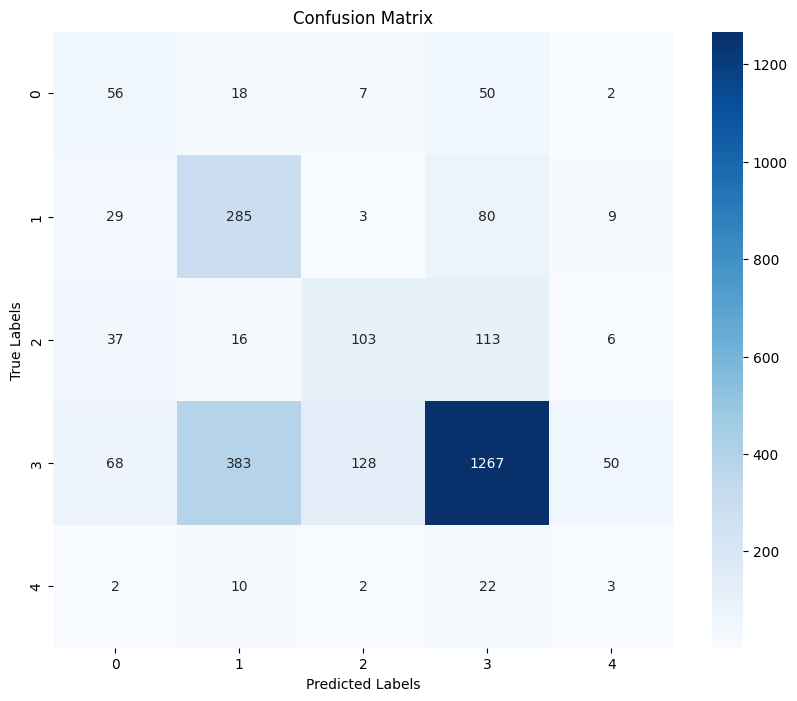

In [77]:

model_path = "SAVE/ORTHOGONAL/LONG_3_CNN.pth"
model = create_cnn_orthogonal_model()
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
accuracy, report = test_model(model, model_path, test_loader, device, show=True)

# Test with prof's function

In [87]:
try:
    import gymnasium as gym
except ModuleNotFoundError:
    print('gymnasium module not found. Try to install with:')
    print('pip install gymnasium[box2d]')
    sys.exit(1)

def close_env_after_timestamps(env, timestamps):
    """Close the environment after a specified number of timestamps."""
    def monitor_timestamps():
        step_count = 0
        while step_count < timestamps:
            time.sleep(0.1)  # Check every 0.1 seconds
            step_count += 1
        env.close()
        print(f"Environment closed after {timestamps} timestamps.")

    threading.Thread(target=monitor_timestamps, daemon=True).start()

def play(env, model, timestamps):
    seed = 1890300
    obs, _ = env.reset(seed=seed)

    # Drop initial frames
    action0 = 0
    for _ in range(50):
        obs, _, _, _, _ = env.step(action0)

    done = False
    steps = 0
    while not done and steps < timestamps:
        # Convert observation to tensor and add batch dimension
        obs_tensor = torch.tensor(obs, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(model.fc1.weight.device)

        # Get predictions from the model
        logits = model(obs_tensor)  # Forward pass
        action = torch.argmax(logits, dim=1).item()  # Get the action

        # Invert actions: if 1 (left) -> 2 (right), and if 2 (right) -> 1 (left)
        if action == 1:  # Left
            action = 2  # Switch to Right
        elif action == 2:  # Right
            action = 1  # Switch to Left

        # Step in the environment
        obs, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        steps += 1

# Environment arguments
env_arguments = {
    'domain_randomize': False,
    'continuous': False,
    'render_mode': 'human'
}

env_name = 'CarRacing-v2'
env = gym.make(env_name, **env_arguments)

# Set a timestamp limit for the environment 
timestamps = 4000
close_env_after_timestamps(env, timestamps)

print("Environment:", env_name)
print("Action space:", env.action_space)
print("Observation space:", env.observation_space)

# Load your trained model
model_path = "SAVE/ORTHOGONAL/LONG_3_CNN.pth"

# Replace with your model creation function
model = create_cnn_orthogonal_model()
model.load_state_dict(torch.load(model_path, weights_only=False)['model_state_dict'])

# Play the game
try:
    play(env, model, timestamps)
except Exception as e:
    print("An error occurred:", e)
finally:
    env.close()
    print("Environment closed.")


Environment: CarRacing-v2
Action space: Discrete(5)
Observation space: Box(0, 255, (96, 96, 3), uint8)
Environment closed.


Environment closed after 4000 timestamps.
